New Price:
        date     price
0 2025-12-29  3965.280
1 2025-12-30  3965.116
2 2025-12-31  3968.840
3 2026-01-05  4023.417
4 2026-01-06  4083.667


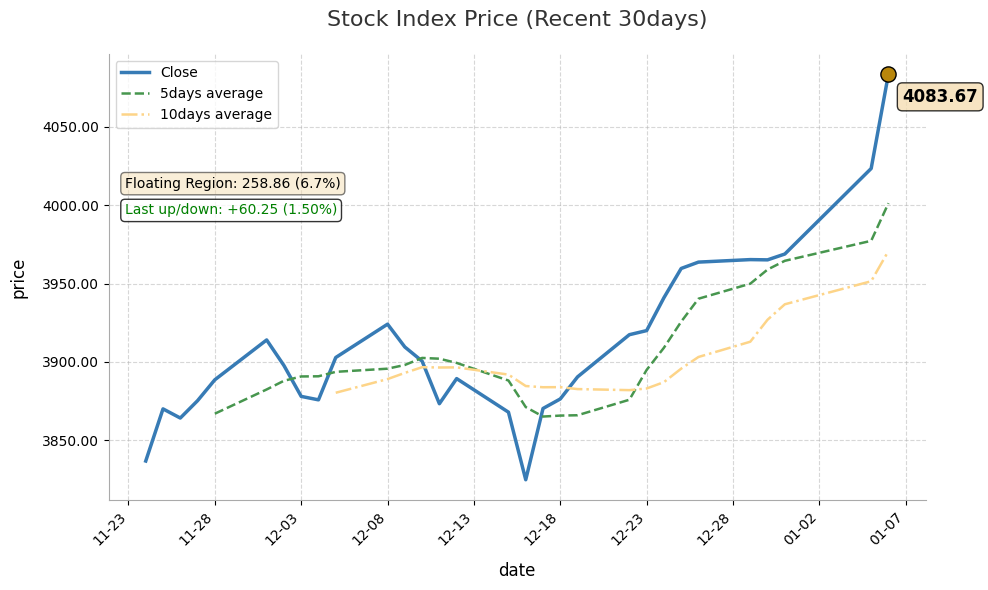


Abstract:
Last New: 4083.67
LDay: +60.25 (+1.50%)
30days highest: 4083.67
30days lowest: 3824.81
5days average: 4001.26
10days average: 3970.79


In [1]:
import akshare as ak
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime, timedelta
import matplotlib.ticker as ticker

# 设置Jupyter图表样式
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

def plot_stock_index_analysis(symbol="sh000001", days=30):
    """
    获取A股指数数据并绘制价格图，显示价格波动区间和最新涨跌信息。

    参数:
    - symbol: A股指数代码，默认为 "sh000001"（上证指数）。
    - days: 显示的天数，默认为 30 天。
    """
    try:
        # 获取A股指数数据
        index_df = ak.stock_zh_index_daily(symbol=symbol)
        
        # 数据清洗和处理
        index_df = index_df[['date', 'close']].copy()
        index_df.columns = ['date', 'price']
        index_df['date'] = pd.to_datetime(index_df['date'])
        index_df['price'] = pd.to_numeric(index_df['price'], errors='coerce')
        
        # 填充空值为0
        index_df.fillna(0, inplace=True)
        
        # 获取最近指定天数的数据
        end_date = datetime.today()
        start_date = end_date - timedelta(days=days + 15)  # 多取一些数据确保有足够的天数
        recent_index = index_df[index_df['date'] >= start_date].sort_values('date')
        
        # 如果数据不足指定天数，使用所有可用数据
        if len(recent_index) < days:
            recent_index = index_df.sort_values('date').tail(days)
        else:
            recent_index = recent_index.tail(days)
            
    except Exception as e:
        print(f"AKShare data get false: {e}")
        return

    # 显示最新价格数据
    print("New Price:")
    print(recent_index[['date', 'price']].tail(5).reset_index(drop=True))

    # 计算统计指标
    last_price = recent_index['price'].iloc[-1]
    prev_price = recent_index['price'].iloc[-2] if len(recent_index) > 1 else last_price
    daily_change = last_price - prev_price
    daily_change_pct = (daily_change / prev_price) * 100

    # 创建专业金融图表
    fig, ax = plt.subplots(figsize=(10, 6))

    # 主价格线 - 蓝色
    ax.plot(recent_index['date'], recent_index['price'], 
            color="#377BB5",
            linewidth=2.5,
            label='Close')

    # 计算并添加移动平均线
    recent_index['MA5'] = recent_index['price'].rolling(window=5).mean()
    recent_index['MA10'] = recent_index['price'].rolling(window=10).mean()
    ax.plot(recent_index['date'], recent_index['MA5'], 
            color="#47964E",
            linestyle='--', 
            linewidth=1.8, 
            label='5days average')
    ax.plot(recent_index['date'], recent_index['MA10'], 
            color="#FDD488",
            linestyle='-.', 
            linewidth=1.8, 
            label='10days average')

    # 标记最新价格点
    last_point = recent_index.iloc[-1]
    ax.scatter(last_point['date'], last_point['price'], 
               s=120, color='#B8860B', edgecolor='black', zorder=10)

    # 最新价格标注
    ax.annotate(f'{last_price:.2f}', 
                (last_point['date'], last_point['price']),
                xytext=(10, -20), 
                textcoords='offset points',
                fontsize=12,
                fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='wheat', alpha=0.8))

    # 设置标题和标签
    ax.set_title('Stock Index Price (Recent 30days)', fontsize=16, pad=20, color='#333333')
    ax.set_xlabel('date', fontsize=12, labelpad=10)
    ax.set_ylabel('price', fontsize=12, labelpad=10)

    # 日期格式化
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    fig.autofmt_xdate(rotation=45)

    # 价格格式化
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.2f}'))

    # 添加网格
    ax.grid(True, linestyle='--', alpha=0.5)

    # 添加图例
    ax.legend(loc='upper left', frameon=True, framealpha=0.8)

    # 添加价格区间信息
    price_range = recent_index['price'].max() - recent_index['price'].min()
    ax.text(0.02, 0.7, 
            f'Floating Region: {price_range:.2f} ({price_range/recent_index["price"].iloc[0]*100:.1f}%)',
            transform=ax.transAxes,
            fontsize=10,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # 添加涨跌信息
    change_color = 'red' if daily_change < 0 else 'green'
    ax.text(0.02, 0.64, 
            f'Last up/down: {"+" if daily_change >= 0 else ""}{daily_change:.2f} ({daily_change_pct:.2f}%)',
            transform=ax.transAxes,
            fontsize=10,
            color=change_color,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # 优化图表边框
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['bottom', 'left']:
        ax.spines[spine].set_color('#AAAAAA')
        ax.spines[spine].set_linewidth(0.8)

    plt.tight_layout()
    plt.show()

    # 显示统计摘要
    print("\nAbstract:")
    print(f"Last New: {last_price:.2f}")
    print(f"LDay: {'+' if daily_change >= 0 else ''}{daily_change:.2f} ({daily_change_pct:+.2f}%)")
    print(f"30days highest: {recent_index['price'].max():.2f}")
    print(f"30days lowest: {recent_index['price'].min():.2f}")
    print(f"5days average: {recent_index['MA5'].iloc[-1]:.2f}")
    print(f"10days average: {recent_index['MA10'].iloc[-1]:.2f}")

# 调用函数
plot_stock_index_analysis()

Recent Volume:
        date       volume
0 2025-12-29  56368719700
1 2025-12-30  52593258800
2 2025-12-31  49075149000
3 2026-01-05  59695045500
4 2026-01-06  70247227000


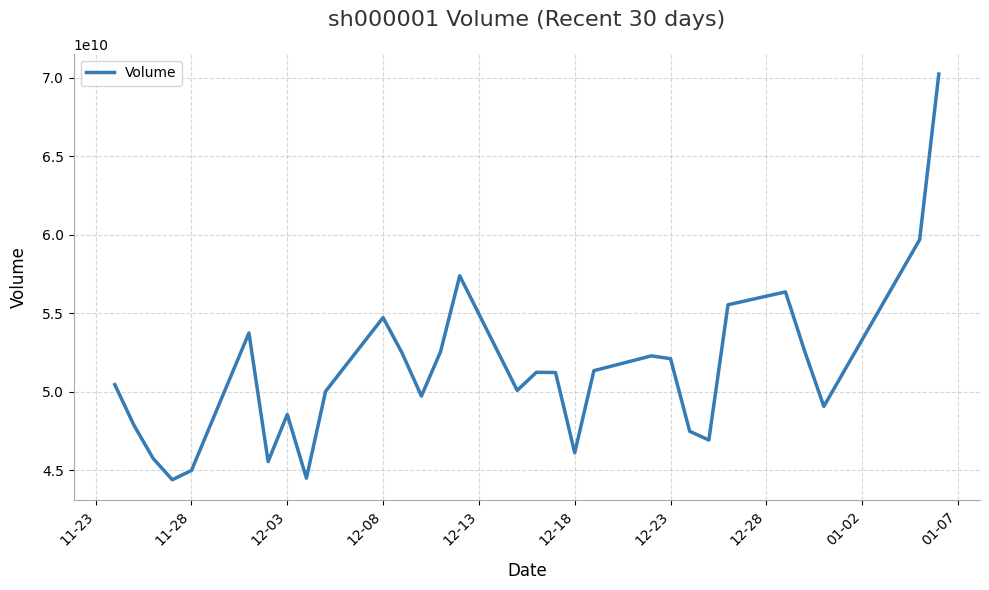

Data saved to sh000001_volume_30_days.csv


In [2]:
import akshare as ak
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime, timedelta
import matplotlib.ticker as ticker

# 设置Jupyter图表样式
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

def plot_stock_index_volume(symbol="sh000001", days=30):
    """
    获取A股指数历史交易量数据并绘制交易量曲线图。

    参数:
    - symbol: A股指数代码，默认为 "sh000001"（上证指数）。
    - days: 历史天数，默认为 30 天。
    """
    try:
        # 获取A股指数历史数据
        index_df = ak.stock_zh_index_daily(symbol=symbol)  # 不复权数据
        index_df = index_df[['date', 'volume']].copy()  # 只保留日期和交易量
        index_df.columns = ['date', 'volume']
        index_df['date'] = pd.to_datetime(index_df['date'])
        index_df['volume'] = pd.to_numeric(index_df['volume'], errors='coerce')

        # 填充空值为0
        index_df.fillna(0, inplace=True)

        # 获取最近指定天数的数据
        end_date = datetime.today()
        start_date = end_date - timedelta(days=days + 15)  # 多取一些数据确保有足够的天数
        recent_index = index_df[index_df['date'] >= start_date].sort_values('date')

        # 如果数据不足指定天数，使用所有可用数据
        if len(recent_index) < days:
            recent_index = index_df.sort_values('date').tail(days)
        else:
            recent_index = recent_index.tail(days)

        # 显示最新交易量数据
        print("Recent Volume:")
        print(recent_index[['date', 'volume']].tail(5).reset_index(drop=True))

        # 绘制交易量曲线图
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(recent_index['date'], recent_index['volume'], color="#377BB5", linewidth=2.5, label='Volume')

        # 设置标题和标签
        ax.set_title(f'{symbol} Volume (Recent {days} days)', fontsize=16, pad=20, color='#333333')
        ax.set_xlabel('Date', fontsize=12, labelpad=10)
        ax.set_ylabel('Volume', fontsize=12, labelpad=10)

        # 日期格式化
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
        fig.autofmt_xdate(rotation=45)

        # 添加网格
        ax.grid(True, linestyle='--', alpha=0.5)

        # 添加图例
        ax.legend(loc='upper left', frameon=True, framealpha=0.8)

        # 优化图表边框
        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)
        for spine in ['bottom', 'left']:
            ax.spines[spine].set_color('#AAAAAA')
            ax.spines[spine].set_linewidth(0.8)

        plt.tight_layout()
        plt.show()

        # 保存数据到CSV文件
        csv_filename = f"{symbol}_volume_{days}_days.csv"
        recent_index.to_csv(csv_filename, index=False)
        print(f"Data saved to {csv_filename}")

    except Exception as e:
        print(f"Error: {e}")

# 调用函数
plot_stock_index_volume(symbol="sh000001", days=30)